# Imports


In [26]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo

# Decision Trees


## Helper Functions

In [27]:
class Columns:
    AGE = "age"
    JOB = "job"
    MARITAL = "marital"
    EDUCATION = "education"
    DEFAULT = "default"
    BALANCE = "balance"
    HOUSING = "housing"
    LOAN = "loan"
    CONTACT = "contact"
    DAY_OF_WEEK = "day_of_week"
    MONTH = "month"
    DURATION = "duration"
    CAMPAIGN = "campaign"
    PASSED_DAYS = "pdays"
    PREVIOUS = "previous"
    PREVIOUS_OUTCOME = "poutcome"
    TARGET = "y"

In [28]:
def plot_roc_curve(y_prob, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [29]:
def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)
    accuracy_score_lib = accuracy_score(y_test, y_pred)

    tn = cm[0][0]
    tp = cm[1][1]
    fn = cm[1][0]
    fp = cm[0][1]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted: 0", "Predicted: 1"],
        yticklabels=["Actual: 0", "Actual: 1"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print(classification_report_output)
    print(f"Accuracy (Calculated): {accuracy}")
    print(f"Accuracy (Library): {accuracy_score_lib}")
    print(f"Recall: {recall}")
    print(f"precision: {precision}")

## Data Exploration

In [30]:
df = pd.read_csv(os.path.join("..", "dataset", "dataset_prepped.csv"))

In [31]:
df.head()

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.519481,3,0,0.092259,1,0,5,0.0,-1,0,...,False,False,False,False,False,True,False,False,False,0
1,0.337662,2,0,0.073067,1,0,5,0.0,-1,0,...,False,False,False,False,False,True,False,False,False,0
2,0.194805,2,0,0.072822,1,1,5,0.0,-1,0,...,False,False,False,False,False,True,False,False,False,0
3,0.376623,-1,0,0.086476,1,0,5,0.0,-1,0,...,False,False,False,False,False,True,False,False,False,0
4,0.194805,-1,0,0.072812,0,0,5,0.0,-1,0,...,False,False,False,False,False,True,False,False,False,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  float64
 1   education          45211 non-null  int64  
 2   default            45211 non-null  int64  
 3   balance            45211 non-null  float64
 4   housing            45211 non-null  int64  
 5   loan               45211 non-null  int64  
 6   day_of_week        45211 non-null  int64  
 7   campaign           45211 non-null  float64
 8   pdays              45211 non-null  int64  
 9   previous           45211 non-null  int64  
 10  poutcome           45211 non-null  int64  
 11  job_admin.         45211 non-null  bool   
 12  job_blue-collar    45211 non-null  bool   
 13  job_entrepreneur   45211 non-null  bool   
 14  job_housemaid      45211 non-null  bool   
 15  job_management     45211 non-null  bool   
 16  job_retired        452

## Modelling

In [33]:
random_state = 42

In [34]:
y = df[[Columns.TARGET]]
x = df.drop(columns=[Columns.TARGET])

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_state
)

In [35]:
x_train

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
3344,0.298701,1,0,0.080511,1,0,15,0.000000,-1,0,...,False,False,False,False,False,False,True,False,False,False
17965,0.402597,1,0,0.085650,1,0,30,0.016129,-1,0,...,False,False,False,True,False,False,False,False,False,False
18299,0.311688,2,0,0.107684,0,0,31,0.048387,-1,0,...,False,False,False,True,False,False,False,False,False,False
10221,0.246753,3,0,0.071723,1,0,11,0.161290,-1,0,...,False,False,False,False,True,False,False,False,False,False
32192,0.493506,1,0,0.104561,0,0,15,0.016129,-1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.337662,1,0,0.082418,0,0,18,0.000000,-1,0,...,False,False,False,False,True,False,False,False,False,False
44732,0.064935,3,0,0.077415,0,0,8,0.000000,92,1,...,False,False,False,False,False,False,False,False,False,True
38158,0.207792,3,0,0.084760,1,0,15,0.000000,-1,0,...,False,False,False,False,False,False,True,False,False,False
860,0.194805,2,0,0.074301,0,0,7,0.000000,-1,0,...,False,False,False,False,False,False,True,False,False,False


In [36]:
y_train

,y
3344,0
17965,0
18299,0
10221,0
32192,1
...,...
11284,1
44732,0
38158,0
860,0


### Basic Decision Tree

This decision tree is just used with the default parameters and no HP tuning.

In [37]:
model_1 = DecisionTreeClassifier(random_state=random_state)
model_1.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [38]:
y_pred_model_1 = model_1.predict(x_test)
y_prob_model_1 = model_1.predict_proba(x_test)[:, 1]

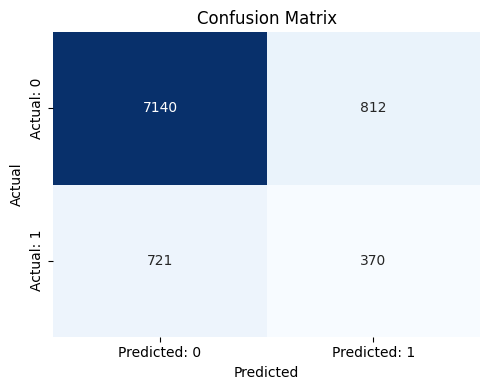

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7952
           1       0.31      0.34      0.33      1091

    accuracy                           0.83      9043
   macro avg       0.61      0.62      0.61      9043
weighted avg       0.84      0.83      0.83      9043

Accuracy (Calculated): 0.8304766117438903
Accuracy (Library): 0.8304766117438903
Recall: 0.3391384051329056
precision: 0.3130287648054145


In [39]:
plot_confusion_matrix(y_pred_model_1, y_test)

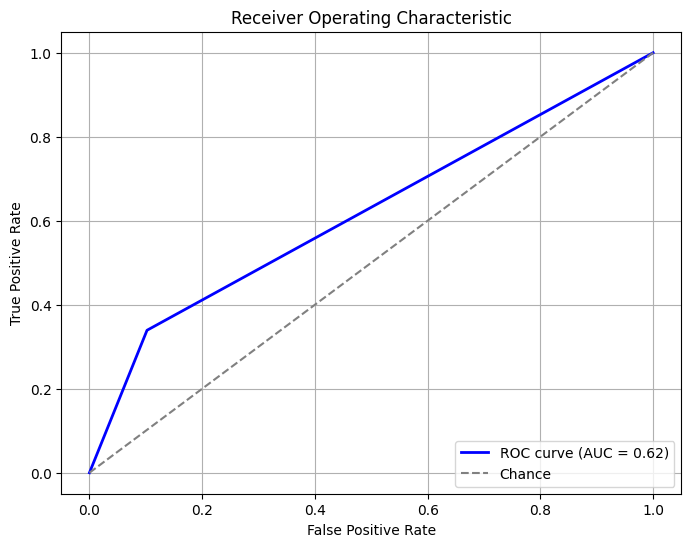

In [40]:
plot_roc_curve(y_prob_model_1, y_test)

### Basic Decision Tree with HP Tuning

In [41]:
print("Hello World")

Hello World
